In [1]:
import csv
import numpy as np
import pandas as pd
import sklearn

In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn import metrics

def analysis(y_pred, y):
    #create decision rule that if probabilty > 0.5 = price increase
    preds = [1 if val > 0.5 else 0 for val in y_pred]
    y_analysis = y.ravel()
    print("AUC score:")
    print(roc_auc_score(y_analysis, y_pred))
    print('\n')
    # Let's binarize and look at the confusion matrix
    print('Confusion Matrix:')
    print(metrics.confusion_matrix(y_analysis, preds))
    print('\n')
    # Lets look at the precision score
    print('Precision Score:')
    print(precision_score(y_analysis, preds))
    print('\n')

# Classification

load data

In [3]:
target = 'pos_target'
#data = pd.read_csv('GOOG_PRICE_FLAIR_SEMANTIC_ENRICHED.csv')
data = pd.read_csv('GOOG_PRICE_MYMODEL_SEMANTIC_ENRICHED.csv')
input_data = data
#remove negative target  
input_data = input_data.drop('neg_target', axis = 1)

#shift price change target so todays sentiment lines up with tomorrows price
input_data[target] = input_data[target].shift(-1)
input_data = input_data[:-1].reset_index(drop=True)

input_data = input_data.dropna(axis=1).select_dtypes(['number']) 
input_data.head()

,volume,timestamp,high,low,close,open,log_change,pos_target,WALL_STREE.text_COUNT_last1days:google,sentiment
0,4018300,1.396544e+09,588.300,566.01,571.50,573.39,0.166128,0.0,2,0.047923
1,3961600,1.396890e+09,549.850,530.53,540.63,544.79,0.071418,1.0,1,0.415801
2,3031600,1.397063e+09,567.800,555.38,567.04,565.84,0.283769,0.0,1,0.479525
3,5614700,1.397754e+09,557.000,539.40,543.34,556.32,-0.274617,1.0,6,0.602720
4,2331100,1.398186e+09,547.995,536.00,545.50,536.00,0.619104,0.0,2,-0.425460


In [4]:
input_data=input_data[['sentiment','log_change','pos_target']]

In [5]:
input_data

,sentiment,log_change,pos_target
0,0.047923,0.166128,0.0
1,0.415801,0.071418,1.0
2,0.479525,0.283769,0.0
3,0.602720,-0.274617,1.0
4,-0.425460,0.619104,0.0
...,...,...,...
472,0.371693,0.271485,1.0
473,0.371693,0.271485,1.0
474,0.873099,0.299884,0.0
475,-0.092425,0.252829,0.0


# Train Tess Split

In [6]:
from sklearn.model_selection import train_test_split
X = input_data.loc[:, input_data.columns != target].values
y = input_data.loc[:,[target]].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Data learning 

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train.ravel())

KNeighborsClassifier()

In [9]:
knn_classifier.score(X_train, y_train)

0.6824146981627297

In [10]:
knn_classifier.score(X_test, y_test)

0.5833333333333334

In [11]:
y_pred_knn = knn_classifier.predict(X_test)

In [12]:
analysis(y_pred_knn, y_test)

AUC score:
0.5618625277161863


Confusion Matrix:
[[39 16]
 [24 17]]


Precision Score:
0.5151515151515151




In [13]:
from sklearn.svm import SVC

In [14]:
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train.ravel())

SVC()

In [15]:
svm_classifier.score(X_train, y_train)

0.6010498687664042

In [16]:
svm_classifier.score(X_test, y_test)

0.6041666666666666

In [17]:
y_pred_svm = svm_classifier.predict(X_test)

In [18]:
analysis(y_pred_svm, y_test)

AUC score:
0.5458980044345898


Confusion Matrix:
[[52  3]
 [35  6]]


Precision Score:
0.6666666666666666




In [19]:
div = int(round(input_data.shape[0] * 0.80))
train = input_data[:div]
test = input_data[div:]
          
X_train = train.loc[:, train.columns != target].values
y_train = train.loc[:,[target]].values

X_test = test.loc[:, test.columns != target].values
y_test = test.loc[:,[target]].values

In [20]:
from sklearn.ensemble import RandomForestRegressor
randomRegressor_classifier = RandomForestRegressor(n_estimators = 3000, criterion='mse')
randomRegressor_classifier.fit(X_train, y_train.ravel()) #convert y-train to linear sequence

RandomForestRegressor(n_estimators=3000)

In [21]:
y_pred_test = randomRegressor_classifier.predict(X_test)
y_pred_train = randomRegressor_classifier.predict(X_train)

In [22]:
analysis(y_pred_test, y_test)

AUC score:
0.6145276292335116


Confusion Matrix:
[[33 11]
 [30 21]]


Precision Score:
0.65625




In [24]:
from yellowbrick.contrib.classifier import DecisionViz
def draw_decision_boundary(classifier):
    feature_pair = ['sentiment', 'price change']
    idx1 = input_data.columns.get_loc('sentiment')
    idx2 = input_data.columns.get_loc('log_change')

    vis = DecisionViz(classifier, features = feature_pair, classes=['negative', 'positive'], is_fitted=True)
    vis.fit(X_train[:,(idx1,idx2)],y_train.ravel())
    vis.draw(X_test[:,(idx1,idx2)],y_test.ravel())
    vis.show()

C:\Users\Ruari\anaconda3\lib\site-packages\yellowbrick\contrib\classifier\boundaries.py:435: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  self.ax.pcolormesh(


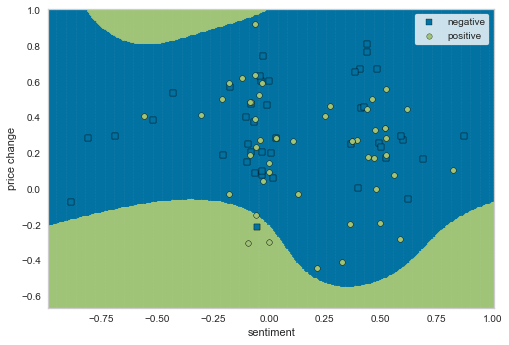

In [25]:
draw_decision_boundary(svm_classifier)

C:\Users\Ruari\anaconda3\lib\site-packages\yellowbrick\contrib\classifier\boundaries.py:435: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  self.ax.pcolormesh(


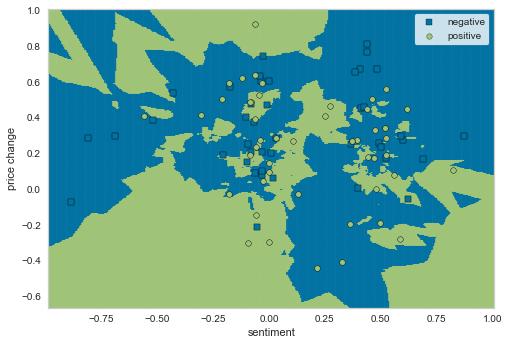

In [26]:
draw_decision_boundary(knn_classifier)